In [ ]:
!pip install transformers peft accelerate torch pandas scikit-learn matplotlib seaborn
!pip install datasets
!pip install optuna

In [ ]:
#### DATASET

import os
import torch
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds


train_dataset, test_dataset = tfds.load(
        'imdb_reviews',
        split=['train', 'test'],
        as_supervised=True
)

print("Train Dataset (First 5 examples):")
for i, (text, label) in enumerate(train_dataset.take(5)):
    print(f"Example {i+1}:")
    print(f"Text: {text.numpy()}")
    print(f"Label: {label.numpy()}")
    print("-" * 50)


In [ ]:
### DATASET TRAIN-VAL-TEST SPLIT
from datasets import load_dataset
from sklearn.model_selection import train_test_split


dataset = load_dataset("imdb")

texts = dataset['train']['text']
labels = dataset['train']['label']

X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train size: 17500, Validation size: 3750, Test size: 3750


In [ ]:
import transformers
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    AdaLoraConfig
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import numpy as np

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
### DATASET TOKENIZATION AND SPLIT

class IMDBDatasetPreparer:
    def __init__(self, model_name='distilbert-base-uncased', max_length=512):
        self.dataset = load_dataset("imdb")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_length = max_length
        self._prepare_splits()

    def _prepare_splits(self):
        texts = self.dataset['train']['text']
        labels = self.dataset['train']['label']
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, labels, test_size=0.3, random_state=42
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42
        )

        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
        self.X_test, self.y_test = X_test, y_test
        print(f"Train size: {len(X_train)}, "
              f"Validation size: {len(X_val)}, "
              f"Test size: {len(X_test)}")

    def tokenize_data(self):
        def tokenize_function(examples):
            return self.tokenizer(
                examples,
                padding='max_length',
                truncation=True,
                max_length=self.max_length
            )

        train_dataset = self._create_torch_dataset(
            self.X_train, self.y_train, tokenize_function
        )
        val_dataset = self._create_torch_dataset(
            self.X_val, self.y_val, tokenize_function
        )
        test_dataset = self._create_torch_dataset(
            self.X_test, self.y_test, tokenize_function
        )

        return {
            'train': train_dataset,
            'validation': val_dataset,
            'test': test_dataset,
            'y_test': self.y_test
        }

    def _create_torch_dataset(self, texts, labels, tokenize_function):

        tokenized_texts = tokenize_function(texts)
        class CustomDataset(torch.utils.data.Dataset):
            def __init__(self, encodings, labels):
                self.encodings = encodings
                self.labels = labels

            def __getitem__(self, idx):
                item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                item['labels'] = torch.tensor(self.labels[idx])
                return item

            def __len__(self):
                return len(self.labels)

        return CustomDataset(tokenized_texts, labels)

In [ ]:
### IMPLEMENTATION OF BASELINE: DistilBERT + IMPLEMENTATION OF PEFT TECHNIQUES: LORA AND ADALORA
### Hyperparameters used are values obtained from hyperparameter tuning performed later in this notebook

class SentimentAnalyzer:
    def __init__(self, dataset_preparer=None, test_size=0.2, random_state=42):
        if dataset_preparer is None:
            dataset_preparer = IMDBDatasetPreparer()
        torch.manual_seed(random_state)
        np.random.seed(random_state)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.dataset_preparer = dataset_preparer
        self.load_data()
        self.tokenizer = dataset_preparer.tokenizer

        self.prepare_datasets()

    def load_data(self):
        tokenized_datasets = self.dataset_preparer.tokenize_data()

        self.X_train = self.dataset_preparer.X_train
        self.y_train = self.dataset_preparer.y_train

        self.X_val = self.dataset_preparer.X_val
        self.y_val = self.dataset_preparer.y_val

        self.X_test = self.dataset_preparer.X_test
        self.y_test = self.dataset_preparer.y_test

        self.tokenized_datasets = tokenized_datasets
        self.num_classes = len(np.unique(self.y_train))
        print(f"Number of classes: {self.num_classes}")
        print(f"Train samples: {len(self.X_train)}")
        print(f"Validation samples: {len(self.X_val)}")
        print(f"Test samples: {len(self.X_test)}")

    def prepare_datasets(self):
        self.lora_train_dataset = self.tokenized_datasets['train']
        self.lora_val_dataset = self.tokenized_datasets['validation']
        self.lora_test_dataset = self.tokenized_datasets['test']

        self.nn_tokenize_train = self.tokenizer(
            list(self.X_train),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        self.nn_tokenize_val = self.tokenizer(
            list(self.X_val),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        self.nn_tokenize_test = self.tokenizer(
            list(self.X_test),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

    def train_lora_model(self):
        model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=self.num_classes
        )

        model = prepare_model_for_kbit_training(model)

        lora_config = LoraConfig(
            r=16,
            lora_alpha=64,
            target_modules=['q_lin', 'v_lin'],
            lora_dropout=0.0124,
            bias="none",
            task_type="SEQ_CLS"
        )

        lora_model = get_peft_model(model, lora_config)

        training_args = TrainingArguments(
            output_dir='./lora_results',
            num_train_epochs=3,
            learning_rate = 0.000479,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=64,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
        )

        trainer = Trainer(
            model=lora_model,
            args=training_args,
            train_dataset=self.lora_train_dataset,
            eval_dataset=self.lora_val_dataset,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        trainer.train()
        lora_predictions = trainer.predict(self.lora_test_dataset)
        lora_preds = np.argmax(lora_predictions.predictions, axis=1)

        print("LoRA Model Performance:")
        print(classification_report(self.y_test, lora_preds))

        return lora_preds


    def train_adalora_model(self):
        model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=self.num_classes
        )

        model = prepare_model_for_kbit_training(model)

        adalora_config = AdaLoraConfig(
            init_r = 8,
            target_r = 16,
            lora_alpha = 32,
            target_modules=['q_lin', 'v_lin'],
            lora_dropout=0.163377,
            bias="none",
            task_type="SEQ_CLS",
        )

        adalora_model = get_peft_model(model, adalora_config)
        count_trainable_parameters(adalora_model)

        training_args = TrainingArguments(
          output_dir='./sentiment_results',
          num_train_epochs=5, 
          learning_rate=9e-05,
          per_device_train_batch_size=16,
          per_device_eval_batch_size=64,
          warmup_steps=500,
          weight_decay=0.01,
          logging_dir='./logs',
          logging_steps=10,
          evaluation_strategy="epoch",
          save_strategy="epoch",
          load_best_model_at_end=True,
      )

        # Trainer
        trainer = Trainer(
            model=adalora_model,
            args=training_args,
            train_dataset=self.lora_train_dataset,
            eval_dataset=self.lora_val_dataset,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        trainer.train()

        adalora_predictions = trainer.predict(self.lora_test_dataset)
        adalora_preds = np.argmax(adalora_predictions.predictions, axis=1)

        print("LoRA Model Performance:")
        print(classification_report(self.y_test, adalora_preds))

        return adalora_preds

    def train_distilbert_baseline(self):
  # === Best Hyperparameter Configuration ===
  # Best Validation Loss: 0.3955
  # Best Params:
  #   learning_rate: 0.00031864170431677275
  #   batch_size: 64
  #   warmup_steps: 339
  #   weight_decay: 0.2463458131107359
  #   num_train_epochs: 7
        model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=self.num_classes
        ).to(self.device)

        training_args = TrainingArguments(
            output_dir='./sentiment_results',
            num_train_epochs=7,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=64,
            warmup_steps=339,
            weight_decay=0.2463,
            logging_dir='./logs',
            logging_steps=10,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            learning_rate = 0.00032
        )
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=self.lora_train_dataset,
            eval_dataset=self.lora_val_dataset,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )

        trainer.train()

        distilbert_predictions = trainer.predict(self.lora_test_dataset)
        distilbert_preds = np.argmax(distilbert_predictions.predictions, axis=1)

        print("DistilBERT Model Performance:")
        print(classification_report(self.y_test, distilbert_preds))

        return distilbert_preds

    def compare_models(self, lora_preds, nn_preds, adalora_preds):
        cm_lora = confusion_matrix(self.y_test, lora_preds, labels=[0, 1, 2])
        cm_nn = confusion_matrix(self.y_test, nn_preds, labels=[0, 1, 2])
        cm_adalora = confusion_matrix(self.y_test, adalora_preds, labels=[0, 1, 2])

        plt.figure(figsize=(18, 6))

        plt.subplot(131)
        sns.heatmap(cm_lora, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Neutral', 'Pos'], yticklabels=['Neg', 'Neutral', 'Pos'])
        plt.title('LoRA Model Confusion Matrix')

        plt.subplot(132)
        sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Neutral', 'Pos'], yticklabels=['Neg', 'Neutral', 'Pos'])
        plt.title('Neural Network Confusion Matrix')

        plt.subplot(133)
        sns.heatmap(cm_adalora, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Neutral', 'Pos'], yticklabels=['Neg', 'Neutral', 'Pos'])
        plt.title('AdaLora Confusion Matrix')

        plt.tight_layout()
        plt.savefig('model_comparison.png')

        print("\nModel Performance Comparison:")
        print("LoRA Classification Report:\n", classification_report(self.y_test, lora_preds, target_names=['Negative', 'Neutral', 'Positive']))
        print("Neural Network Classification Report:\n", classification_report(self.y_test, nn_preds, target_names=['Negative', 'Neutral', 'Positive']))
        print("AdaLora Classification Report:\n", classification_report(self.y_test, adalora_preds, target_names=['Negative', 'Neutral', 'Positive']))


In [ ]:
 def count_trainable_parameters(model):
      """
      Count the number of trainable parameters in the model

      Args:
          model: PyTorch model

      Returns:
          int: Number of trainable parameters
          int: Total number of parameters
      """
      trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
      total_params = sum(p.numel() for p in model.parameters())

      print(f"Trainable parameters: {trainable_params:,}")
      print(f"Total parameters: {total_params:,}")
      print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")

      return trainable_params, total_params

In [ ]:
analyzer = SentimentAnalyzer()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Train size: 17500, Validation size: 3750, Test size: 3750
Using device: cuda
Number of classes: 2
Train samples: 17500
Validation samples: 3750
Test samples: 3750


In [ ]:
y_test = analyzer.y_test

In [ ]:
adalora_predictions = analyzer.train_adalora_model()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Trainable parameters: 813,458
Total parameters: 67,768,480
Percentage of trainable parameters: 1.20%


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.239800,0.326190
2,0.284900,0.262536


Epoch,Training Loss,Validation Loss
1,0.239800,0.326190
2,0.284900,0.262536
3,0.239900,0.252916
4,0.310400,0.250382
5,0.272100,0.246327


LoRA Model Performance:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1848
           1       0.90      0.90      0.90      1902

    accuracy                           0.90      3750
   macro avg       0.90      0.90      0.90      3750
weighted avg       0.90      0.90      0.90      3750



In [ ]:
lora_preds = analyzer.train_lora_model()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.173900,0.251792
2,0.167100,0.222640
3,0.143700,0.233898


LoRA Model Performance:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1848
           1       0.94      0.89      0.92      1902

    accuracy                           0.92      3750
   macro avg       0.92      0.92      0.92      3750
weighted avg       0.92      0.92      0.92      3750



In [ ]:
distil = analyzer.train_distilbert_baseline()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.146400,0.245936
2,0.167000,0.293999
3,0.023200,0.313245


DistilBERT Model Performance:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1848
           1       0.92      0.89      0.91      1902

    accuracy                           0.91      3750
   macro avg       0.91      0.91      0.91      3750
weighted avg       0.91      0.91      0.91      3750



In [ ]:
import pandas as pd

error_analysis_df = pd.DataFrame({
    'Text': analyzer.X_test,
    'True Label': analyzer.y_test,
    'AdaLoRA Prediction': adalora_predictions,
    'LoRA Prediction': lora_preds,
    'DistilBERT Prediction': distil
})
pd.set_option('display.max_colwidth', 100)
adalora_errors = error_analysis_df[error_analysis_df['AdaLoRA Prediction'] != error_analysis_df['True Label']]
lora_errors = error_analysis_df[error_analysis_df['LoRA Prediction'] != error_analysis_df['True Label']]
distil_errors = error_analysis_df[error_analysis_df['DistilBERT Prediction'] != error_analysis_df['True Label']]

print("AdaLoRA Errors:")
print(adalora_errors[['Text', 'True Label', 'AdaLoRA Prediction']].head(10))  # Display top 10 errors for AdaLoRA

print("\nLoRA Errors:")
print(lora_errors[['Text', 'True Label', 'LoRA Prediction']].head(10))  # Display top 10 errors for LoRA

print("\nDistilBERT Errors:")
print(distil_errors[['Text', 'True Label', 'DistilBERT Prediction']].head(10))  # Display top 10 errors for DistilBERT

def detailed_error_analysis(errors_df, model_name):
    false_positives = errors_df[errors_df['True Label'] == 0]  # Assuming '0' is negative class
    false_negatives = errors_df[errors_df['True Label'] == 1]  # Assuming '1' is positive class

    print(f"\nError Analysis for {model_name}:")
    print(f"False Positives: {len(false_positives)}")
    print(f"False Negatives: {len(false_negatives)}")

detailed_error_analysis(adalora_errors, 'AdaLoRA')
detailed_error_analysis(lora_errors, 'LoRA')
detailed_error_analysis(distil_errors, 'DistilBERT')


AdaLoRA Errors:
                                                                                                   Text  \
2   "Scary Movie 2" is a let down to the Scary Movie Franchise. Scary Movie 1, 3 and 4 were all good...   
23  In Panic In The Streets Richard Widmark plays U.S. Navy doctor who has his week rudely interrupt...   
24  Welcome to Our Town, welcome to your town? As we are introduced into the worlds of its townsfolk...   
40  So, finally I know it exists. Along with the other Uk contributors on here I saw this on what MU...   
41  A small funny film. It is totally incredible, unbelievable, impossible. But it is funny how an i...   
43  Does anyone know, where I can see or download the "What I like about you" season 4 episodes in t...   
50  John Carradine, John Ireland, and Faith Domergue who as players all saw better days in better fi...   
69  I like Brad Pitt enormously. He is an actor with brains and wit, not to mention face, pectorals ...   
73  Mitchell Leisen's

In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'True Label': y_test,
    'DistilBERT Prediction': distil,
    'LoRA Prediction': lora_preds,
    'AdaLoRA Prediction': adalora_predictions
})
df['DistilBERT Error'] = df['True Label'] != df['DistilBERT Prediction']
df['LoRA Error'] = df['True Label'] != df['LoRA Prediction']
df['AdaLoRA Error'] = df['True Label'] != df['AdaLoRA Prediction']
distil_lora_errors = df[(df['DistilBERT Error']) & (df['LoRA Error']) & ~(df['AdaLoRA Error'])]
distil_adalora_errors = df[(df['DistilBERT Error']) & (df['AdaLoRA Error']) & ~(df['LoRA Error'])]

lora_adalora_errors = df[(df['LoRA Error']) & (df['AdaLoRA Error']) & ~(df['DistilBERT Error'])]

print(f"Errors common between DistilBERT and LoRA: {len(distil_lora_errors)}")
print(f"\nErrors common between DistilBERT and AdaLoRA: {len(distil_adalora_errors)}")
print(f"\nErrors common between LoRA and AdaLoRA: {len(lora_adalora_errors)}")

Errors common between DistilBERT and LoRA: 51

Errors common between DistilBERT and AdaLoRA: 42

Errors common between LoRA and AdaLoRA: 50


In [ ]:
### HYPERPARAMETER TUNING for AdaLoRA (same code was modified with minimal changes for LoRA)

import optuna
import numpy as np
import torch
from transformers import (
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from peft import (
    prepare_model_for_kbit_training,
    get_peft_model,
    AdaLoraConfig
)
from sklearn.metrics import classification_report

class AdaLoRAHyperparameterTuner:
    def __init__(self, train_dataset, val_dataset, num_classes):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.num_classes = num_classes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def objective(self, trial):
        init_r = trial.suggest_categorical('init_r', [8, 16, 32])
        target_r = trial.suggest_categorical('target_r', [16, 32, 64])
        lora_alpha = trial.suggest_categorical('lora_alpha', [16, 32, 64])
        lora_dropout = trial.suggest_loguniform('lora_dropout', 0.01, 0.3)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
        batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
        model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=self.num_classes
        )

        model = prepare_model_for_kbit_training(model)

        adalora_config = AdaLoraConfig(
            init_r=init_r,
            target_r=target_r,
            lora_alpha=lora_alpha,
            target_modules=['q_lin', 'v_lin'],
            lora_dropout=lora_dropout,
            bias="none",
            task_type="SEQ_CLS",
        )

        adalora_model = get_peft_model(model, adalora_config)
        adalora_model.to(self.device)

        training_args = TrainingArguments(
            output_dir='./adalora_tuning',
            num_train_epochs=3,
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size * 2,
            warmup_steps=100,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model='eval_loss'
        )

        trainer = Trainer(
            model=adalora_model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.val_dataset,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        trainer.train()
        eval_results = trainer.evaluate()
        return eval_results['eval_loss']

    def tune_hyperparameters(self, n_trials=20):
        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=n_trials)
        print("Best trial:")
        trial = study.best_trial
        print(f"  Value (lowest validation loss): {trial.value}")
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")
        return trial.params

    def train_best_model(self, best_params):
        model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=self.num_classes
        )

        model = prepare_model_for_kbit_training(model)
        adalora_config = AdaLoraConfig(
            r=best_params['r'],
            lora_alpha=best_params['lora_alpha'],
            target_modules=['q_lin', 'v_lin'],
            lora_dropout=best_params['lora_dropout'],
            bias="none",
            task_type="SEQ_CLS",
        )

        adalora_model = get_peft_model(model, adalora_config)
        training_args = TrainingArguments(
            output_dir='./final_adalora_model',
            num_train_epochs=3,
            learning_rate=best_params['learning_rate'],
            per_device_train_batch_size=best_params['batch_size'],
            per_device_eval_batch_size=best_params['batch_size'] * 2,
            warmup_steps=100,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
        )

        trainer = Trainer(
            model=adalora_model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.val_dataset,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        trainer.train()

        test_predictions = trainer.predict(self.test_dataset)
        test_preds = np.argmax(test_predictions.predictions, axis=1)

        print("Final Model Performance:")
        print(classification_report(self.y_test, test_preds))

        return adalora_model, test_preds


In [ ]:
dataset_preparer = IMDBDatasetPreparer(
        model_name='distilbert-base-uncased', 
        max_length=256
    )

processed_datasets = dataset_preparer.tokenize_data()

In [ ]:
tuner = AdaLoRAHyperparameterTuner(
    train_dataset=processed_datasets['train'],
    val_dataset=processed_datasets['validation'],
    num_classes=2
)

best_params = tuner.tune_hyperparameters(n_trials=15)

final_model, predictions = tuner.train_best_model(best_params)

In [ ]:
### HYPERPARAMETER TUNING for DistilBERT
import torch
import numpy as np
import optuna
from transformers import (
    DistilBertForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
import logging

class DistilBERTHyperparameterTuner:
    def __init__(self, train_dataset, val_dataset, num_classes):

        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.num_classes = num_classes
        
        if torch.cuda.is_available():
            self.device = torch.device(f"cuda:{self._select_gpu()}")
        else:
            raise RuntimeError("No CUDA devices available. Cannot proceed with GPU training.")
        
        print(f"Using device: {self.device}")
        self.model = None
        self.best_model = None
        self.best_metrics = None

    def _select_gpu(self):
        free_memory = []
        for i in range(torch.cuda.device_count()):
            torch.cuda.set_device(i)
            free_memory.append(torch.cuda.mem_get_info()[0])
        
        return free_memory.index(max(free_memory))

    def compute_metrics(self, pred):
        predictions = np.argmax(pred.predictions, axis=1)
        labels = pred.label_ids

        accuracy = accuracy_score(labels, predictions)
        f1 = f1_score(labels, predictions, average='weighted')
        
        return {
            'accuracy': accuracy,
            'f1_score': f1
        }

    def objective(self, trial):
        self.model = DistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            num_labels=self.num_classes
        ).to(self.device)

        learning_rate = trial.suggest_float("learning_rate", 5e-6, 5e-4, log=True)
        batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
        warmup_steps = trial.suggest_int("warmup_steps", 0, 500)
        weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
        num_train_epochs = trial.suggest_int("num_train_epochs", 2, 10)

        training_args = TrainingArguments(
            output_dir="./optuna_results",
            evaluation_strategy="epoch",
            save_strategy="epoch",
            logging_dir="./logs",
            logging_steps=10,
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_train_epochs,
            warmup_steps=warmup_steps,
            weight_decay=weight_decay,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
        )
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.val_dataset,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )

        trainer.train()
        eval_results = trainer.evaluate()
    
        if self.best_model is None or eval_results["eval_loss"] < self.best_metrics:
            self.best_model = self.model
            self.best_metrics = eval_results["eval_loss"]
            self.best_params = trial.params
        return eval_results["eval_loss"]

    def tune_hyperparameters(self, n_trials=20):
        print("\n=== Starting Hyperparameter Tuning ===")
        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=n_trials)

        print("\n=== Best Hyperparameter Configuration ===")
        trial = study.best_trial
        print(f"  Best Validation Loss: {trial.value:.4f}")
        print("  Best Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        if self.best_model is not None:
            best_training_args = TrainingArguments(
                output_dir="./best_model_results",
                evaluation_strategy="epoch",
                per_device_eval_batch_size=self.best_params.get('batch_size', 32),
                device=self.device
            )
            
            best_trainer = Trainer(
                model=self.best_model,
                args=best_training_args,
                eval_dataset=self.val_dataset,
                compute_metrics=self.compute_metrics
            )
            
            eval_results = best_trainer.evaluate()
            
            print("\n=== Best Model Metrics ===")
            print(f"  Accuracy: {eval_results['eval_accuracy']:.4f}")
            print(f"  F1 Score: {eval_results['eval_f1_score']:.4f}")

        return {
            'best_params': trial.params,
            'best_validation_loss': trial.value,
            'accuracy': eval_results['eval_accuracy'],
            'f1_score': eval_results['eval_f1_score']
        }

In [ ]:
tuner = DistilBERTHyperparameterTuner(
    train_dataset=processed_datasets['train'],
    val_dataset=processed_datasets['validation'],
    num_classes=2
)

best_params = tuner.tune_hyperparameters(n_trials=15)

In [ ]:
### BASELINES: LOGISTIC REGRESSION WITH TF-IDF

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

class LogisticRegressionBaseline:
    def __init__(self, dataset_preparer):
        self.dataset_preparer = dataset_preparer
        self.dataset_preparer._prepare_splits()

    def create_pipeline(self):
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                stop_words='english', 
                max_features=5000,
                ngram_range=(1, 2) 
            )),
            ('classifier', LogisticRegression(
                max_iter=1000, 
                solver='liblinear' 
            ))
        ])

        return pipeline

    def perform_grid_search(self):
        pipeline = self.create_pipeline()
        param_grid = {
            'tfidf__max_features': [7000], #[3000, 5000, 7000], MODIFIED AFTER FINDING OPTIMAL HYPERPARAMS
            'tfidf__ngram_range': [(1, 2)],  ## [(1, 1), (1, 2), (1, 3)],
            'classifier__C': [1], ## [0.1, 1, 10]
            'classifier__penalty': ['l2']  # [l1, l2]
        }

        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            verbose = 2
        )
        grid_search.fit(self.dataset_preparer.X_train, self.dataset_preparer.y_train)

        print("Best Parameters:", grid_search.best_params_)
        print("Best Cross-Validation Score:", grid_search.best_score_)

        return grid_search.best_estimator_

    def evaluate(self, model):
        y_pred = model.predict(self.dataset_preparer.X_test)
        print("\nClassification Report:")
        print(classification_report(self.dataset_preparer.y_test, y_pred))
        accuracy = accuracy_score(self.dataset_preparer.y_test, y_pred)
        print(f"\nOverall Accuracy: {accuracy:.4f}")

        return {
            'predictions': y_pred,
            'accuracy': accuracy,
            'classification_report': classification_report(
                self.dataset_preparer.y_test, y_pred, output_dict=True
            )
        }

In [ ]:
dataset_preparer = IMDBDatasetPreparer()

Train size: 17500, Validation size: 3750, Test size: 3750


In [ ]:
baseline = LogisticRegressionBaseline(dataset_preparer)

Train size: 17500, Validation size: 3750, Test size: 3750


In [ ]:
model = baseline.perform_grid_search()

results = baseline.evaluate(model)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Score: 0.873486124864611

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1848
           1       0.87      0.89      0.88      1902

    accuracy                           0.88      3750
   macro avg       0.88      0.88      0.88      3750
weighted avg       0.88      0.88      0.88      3750


Overall Accuracy: 0.8784


In [ ]:
lr_preds = results['predictions']
len(lr_preds)

3750

In [ ]:
analyzer.X_test[:3]

["It's very sly for all of the 60's look to the movie. The humor is quite gentle, but it grew on me much more than I expected. The cast is first-rate and they appear to be having a wonderful time. Ustinov wanders through the film muttering some quite funny things under his breath, and it's all very inconsequential; I'll buy the movie as soon as it comes out on DVD. The plot is that Ustinov as an embezzler released from prison posing as a computer whiz and embezzling money from an American company with an office in London. Maggie Smith is his secretary for a while, and watching her get fired from many different jobs is part of the fun. Bob Newhart is his usual deadpan self, and Karl Malden has fun as the dense and sleazy executive running the London office. The ending is funny and nicely cynical.",
 'The various nudity scenes that other reviewers referred to are poorly done and a body double was obviously used. If Ms. Pacula was reluctant to do the scenes herself perhaps she should have

In [ ]:
dataset_preparer.X_test[:3]

["It's very sly for all of the 60's look to the movie. The humor is quite gentle, but it grew on me much more than I expected. The cast is first-rate and they appear to be having a wonderful time. Ustinov wanders through the film muttering some quite funny things under his breath, and it's all very inconsequential; I'll buy the movie as soon as it comes out on DVD. The plot is that Ustinov as an embezzler released from prison posing as a computer whiz and embezzling money from an American company with an office in London. Maggie Smith is his secretary for a while, and watching her get fired from many different jobs is part of the fun. Bob Newhart is his usual deadpan self, and Karl Malden has fun as the dense and sleazy executive running the London office. The ending is funny and nicely cynical.",
 'The various nudity scenes that other reviewers referred to are poorly done and a body double was obviously used. If Ms. Pacula was reluctant to do the scenes herself perhaps she should have

In [ ]:
### ERROR ANALYSIS
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'True Label': y_test,
    'DistilBERT Prediction': distil,
    'LoRA Prediction': lora_preds,
    'AdaLoRA Prediction': adalora_predictions,
    'Logistic Regression Prediction': lr_preds, 
    'Text': analyzer.X_test
})
df['DistilBERT Error'] = df['True Label'] != df['DistilBERT Prediction']
df['LoRA Error'] = df['True Label'] != df['LoRA Prediction']
df['AdaLoRA Error'] = df['True Label'] != df['AdaLoRA Prediction']
df['Logistic Regression Error'] = df['True Label'] != df['Logistic Regression Prediction'] 

distil_lora_errors = df[(df['DistilBERT Error']) & (df['LoRA Error']) & ~(df['AdaLoRA Error']) & ~(df['Logistic Regression Error'])]

distil_adalora_errors = df[(df['DistilBERT Error']) & (df['AdaLoRA Error']) & ~(df['LoRA Error']) & ~(df['Logistic Regression Error'])]
distil_lr_errors = df[(df['DistilBERT Error']) & (df['Logistic Regression Error']) & ~(df['LoRA Error']) & ~(df['AdaLoRA Error'])]
lora_adalora_errors = df[(df['LoRA Error']) & (df['AdaLoRA Error']) & ~(df['DistilBERT Error']) & ~(df['Logistic Regression Error'])]
lora_lr_errors = df[(df['LoRA Error']) & (df['Logistic Regression Error']) & ~(df['DistilBERT Error']) & ~(df['AdaLoRA Error'])]
adalora_lr_errors = df[(df['AdaLoRA Error']) & (df['Logistic Regression Error']) & ~(df['DistilBERT Error']) & ~(df['LoRA Error'])]
all_three_errors = df[(df['DistilBERT Error']) & (df['LoRA Error']) & (df['AdaLoRA Error']) & (df['Logistic Regression Error'])]

Errors common between DistilBERT and LoRA: 31

Errors common between DistilBERT and AdaLoRA: 19

Errors common between DistilBERT and Logistic Regression: 25

Errors common between LoRA and AdaLoRA: 26

Errors common between LoRA and Logistic Regression: 15

Errors common between AdaLoRA and Logistic Regression: 42

Errors common between all three models: 100


In [ ]:
!pip install matplotlib-venn

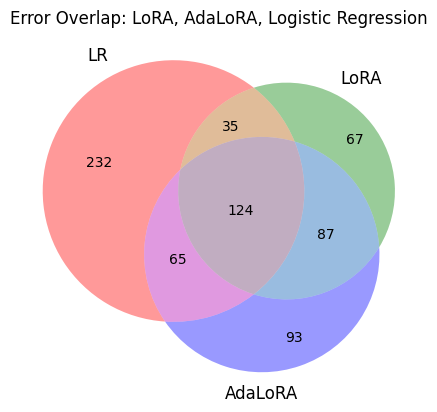

In [ ]:
### ERROR ANALYSIS

from matplotlib_venn import venn3
import matplotlib.pyplot as plt
only_lora = len(df[(df['LoRA Error']) & ~df['AdaLoRA Error'] & ~df['Logistic Regression Error']])
only_adalora = len(df[(df['AdaLoRA Error']) & ~df['LoRA Error'] & ~df['Logistic Regression Error']])
only_lr = len(df[(df['Logistic Regression Error']) & ~df['LoRA Error'] & ~df['AdaLoRA Error']])

lora_adalora = len(df[(df['LoRA Error']) & df['AdaLoRA Error'] & ~df['Logistic Regression Error']])
lora_lr = len(df[(df['LoRA Error']) & df['Logistic Regression Error'] & ~df['AdaLoRA Error']])
adalora_lr = len(df[(df['AdaLoRA Error']) & df['Logistic Regression Error'] & ~df['LoRA Error']])

all_three = len(df[(df['LoRA Error']) & df['AdaLoRA Error'] & df['Logistic Regression Error']])

venn3(
    subsets=(only_lr, only_lora, lora_lr, only_adalora, adalora_lr, lora_adalora, all_three),
    set_labels=('LR', 'LoRA', 'AdaLoRA')
)
plt.title("Error Overlap: LoRA, AdaLoRA, Logistic Regression")
plt.show()



In [ ]:
### CHECK FOR NEGATIONS
def count_negations(text):
    negation_words = [" not ", " no ", "n't", "never", " nor ", "neither", " none "]
    return sum(text.lower().count(neg) for neg in negation_words)

df['Contains Negation'] = df['Text'].apply(count_negations)

distilbert_errors = df['DistilBERT Error'].sum()
lora_errors = df['LoRA Error'].sum()
adalora_errors = df['AdaLoRA Error'].sum()
lr_errors = df['Logistic Regression Error'].sum()

distilbert_negation_errors = df[df['DistilBERT Error'] & df['Contains Negation']].shape[0]
lora_negation_errors = df[df['LoRA Error'] & df['Contains Negation']].shape[0]
adalora_negation_errors = df[df['AdaLoRA Error'] & df['Contains Negation']].shape[0]
lr_negation_errors = df[df['Logistic Regression Error'] & df['Contains Negation']].shape[0]

df['Correct Classification'] = ~(
    df['DistilBERT Error'] | df['LoRA Error'] | df['AdaLoRA Error'] | df['Logistic Regression Error']
)

correct_with_negations = df[df['Correct Classification'] & df['Contains Negation']].shape[0]

avg_negations_correct = df[df['Correct Classification']]['Negation Count'].mean()
avg_negations_incorrect = df[~df['Correct Classification']]['Negation Count'].mean()

print(f"Total Errors:")
print(f"DistilBERT: {distilbert_errors}")
print(f"LoRA: {lora_errors}")
print(f"AdaLoRA: {adalora_errors}")
print(f"Logistic Regression: {lr_errors}")

print("\nErrors with Negations:")
print(f"DistilBERT: {distilbert_negation_errors}")
print(f"LoRA: {lora_negation_errors}")
print(f"AdaLoRA: {adalora_negation_errors}")
print(f"Logistic Regression: {lr_negation_errors}")

print(f"\nCorrectly classified with Negations: {correct_with_negations}")

print("\nAverage Negations:")
print(f"Correctly Classified: {avg_negations_correct:.2f}")
print(f"Incorrectly Classified: {avg_negations_incorrect:.2f}")

In [ ]:
### CHECK FOR CONTRAST WORDS
def count_contrast_words(text):
    contrast_words = ["but", "although", "however", "though", "yet"]
    return sum(text.lower().count(word) for word in contrast_words)

df['Contrast Word Count'] = df['Text'].apply(count_contrast_words)

distilbert_errors = df['DistilBERT Error'].sum()
lora_errors = df['LoRA Error'].sum()
adalora_errors = df['AdaLoRA Error'].sum()
lr_errors = df['Logistic Regression Error'].sum()

df['Correct Classification'] = ~(
    df['DistilBERT Error'] | df['LoRA Error'] | df['AdaLoRA Error'] | df['Logistic Regression Error']
)
avg_contrast_correct = df[df['Correct Classification']]['Contrast Word Count'].mean()
avg_contrast_incorrect = df[~df['Correct Classification']]['Contrast Word Count'].mean()

print(f"Total Errors:")
print(f"DistilBERT: {distilbert_errors}")
print(f"LoRA: {lora_errors}")
print(f"AdaLoRA: {adalora_errors}")
print(f"Logistic Regression: {lr_errors}")

print("\nAverage Contrast Word Counts:")
print(f"Correctly Classified: {avg_contrast_correct:.2f}")
print(f"Incorrectly Classified: {avg_contrast_incorrect:.2f}")

distilbert_avg_contrast_errors = df[df['DistilBERT Error']]['Contrast Word Count'].mean()
lora_avg_contrast_errors = df[df['LoRA Error']]['Contrast Word Count'].mean()
adalora_avg_contrast_errors = df[df['AdaLoRA Error']]['Contrast Word Count'].mean()
lr_avg_contrast_errors = df[df['Logistic Regression Error']]['Contrast Word Count'].mean()

print("\nAverage Contrast Word Counts in Errors by Model:")
print(f"DistilBERT Errors: {distilbert_avg_contrast_errors:.2f}")
print(f"LoRA Errors: {lora_avg_contrast_errors:.2f}")
print(f"AdaLoRA Errors: {adalora_avg_contrast_errors:.2f}")
print(f"Logistic Regression Errors: {lr_avg_contrast_errors:.2f}")


Total Errors:
DistilBERT: 349
LoRA: 313
AdaLoRA: 369
Logistic Regression: 456

Average Contrast Word Counts:
Correctly Classified: 2.48
Incorrectly Classified: 2.90

Average Contrast Word Counts in Errors by Model:
DistilBERT Errors: 3.09
LoRA Errors: 3.00
AdaLoRA Errors: 2.92
Logistic Regression Errors: 2.73


In [ ]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

only_distilbert = len(df[(df['DistilBERT Error']) & ~df['LoRA Error'] & ~df['AdaLoRA Error']])
only_lora = len(df[(df['LoRA Error']) & ~df['DistilBERT Error'] & ~df['AdaLoRA Error']])
only_adalora = len(df[(df['AdaLoRA Error']) & ~df['DistilBERT Error'] & ~df['LoRA Error']])

distil_lora = len(df[(df['DistilBERT Error']) & df['LoRA Error'] & ~df['AdaLoRA Error']])
distil_adalora = len(df[(df['DistilBERT Error']) & df['AdaLoRA Error'] & ~df['LoRA Error']])
lora_adalora = len(df[(df['LoRA Error']) & df['AdaLoRA Error'] & ~df['DistilBERT Error']])

all_three = len(df[(df['DistilBERT Error']) & df['LoRA Error'] & df['AdaLoRA Error']])

venn3(
    subsets=(only_distilbert, only_lora, distil_lora, only_adalora, distil_adalora, lora_adalora, all_three),
    set_labels=('DistilBERT', 'LoRA', 'AdaLoRA')
)
plt.title("Error Overlap: DistilBERT, LoRA, AdaLoRA")
plt.show()


NameError: name 'df' is not defined